# Set Up

## imports

In [7]:
import pandas as pd
import numpy as np

import os
from tqdm import tqdm
import warnings

import plotly.express as px
import plotly.io as po
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import sympy #미분
import math # arctangent; math.atan 사용 목적
import statistics

## Directory

In [8]:
# 중간결과 파일 저장 경로
angle_dir = 'D:/OneDrive - 연세대학교 (Yonsei University)/Projects/Yonsei_TELab/003_도로상충_210517-/2차년도_2022/36_남양주TG+서울TG_급진로변경분석/남양주TG_서울방향/중간과정'

In [9]:
# 최종결과 파일 저장 경로
save_dir = 'D:/OneDrive - 연세대학교 (Yonsei University)/Projects/Yonsei_TELab/003_도로상충_210517-/2차년도_2022/36_남양주TG+서울TG_급진로변경분석/남양주TG_서울방향'

In [10]:
folder_dir = 'D:/OneDrive - 연세대학교 (Yonsei University)/Projects/Yonsei_TELab/003_도로상충_210517-/2차년도_2022/27_남양주영업소_드론영상분석/서울방향'

## Load Datasets

In [11]:
folder_name = '01_density_by_target_LOS_concated_lanechange'

file_dir = os.path.join(folder_dir, folder_name)

In [12]:
file_list = os.listdir(file_dir)
file_list = file_list[:6]

file_list

['01_1_A.csv',
 '01_2_A.csv',
 '01_3_A.csv',
 '02_1_A.csv',
 '02_2_A.csv',
 '02_3_A.csv']

In [13]:
df_list = []
num_LOS_list = []

for file in file_list:
    num_LOS = file[0:6]
    
    file_path = os.path.join(file_dir, file)
    
    globals()[f'target{num_LOS}'] = pd.read_csv(file_path, encoding = 'cp949')
    
    df_list.append(globals()[f'target{num_LOS}'])
    num_LOS_list.append(num_LOS)

In [14]:
df_list[0].head(3) # 01_1_A.csv

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Vehicle ID,Frame ID,Total Frames,Global Time (Epoch Time),Local X (m),...,Spacing Headway,Time Headway,Bad Object,Special Car,Lane Class,Vehicle Movement,Lane_record,Lane_00,Lane_99,Lane_change
0,0,0,0,0,0,2,375,69,46812500,210.387054,...,0.0,0.0,0,0,상행본선,10.826056,U2,U2,U2,NaN
1,1,1,1,1,1,2,390,84,46813000,199.604111,...,0.0,0.0,0,0,상행본선,10.787470,U2,U2,U2,NaN
2,2,2,2,2,2,4,390,69,46813000,209.721069,...,0.0,0.0,0,0,상행본선,11.182503,U1,U1,U1,NaN


# 급진로변경 표시
* **급진로변경**
    * 속도가 30km/h 이상에서
    * 진행방향이 좌측 또는 우측 6도/sec 이상으로 차로변경하고
    * 5초간 누적각도가 +-2도/sec 이하
    * 가감속이 초당 +=2km/h이하인 경우
* **tan(x)**
    * tan6 : `math.tan(math.pi/60)`
    * tan(-6) : - 0.5773502691896257
    * tan2 : `math.tan(math.pi/90)`
    * tan(-2) : -tan2
* **과정**
    1. 각 차량의 각도차를 구한다.
    2. 누적각도를 구한다.
    3. 급진로변경 판정
    4. 원본 .csv 파일 저장
    5. 해당 지점을 산점도로 표시한 .plotly 파일 저장
    6. 급진로변경 건수를 저장한 피벗테이블 저장

## Load Dataset

### 차량별 좌표별 이동 벡터 구하기
* A : 각 대상지별, 서비스수준별 차량 데이터에 대하여, 현재 (x,y) 좌표와 다음(x', y') 좌표에 대하여 기울기를 구한다.

In [15]:
warnings.filterwarnings(action = 'ignore') # pandas 경고메시지 숨기기

slope_df_list = []

for df, num_LOS in tqdm(zip(df_list, num_LOS_list)):
    # 차량별 이동 동선을 써야 함
    vehicle_list = df['Vehicle ID'].unique()
    
    slope_df = pd.DataFrame()
    
    for veh in vehicle_list: # 각 차량별로
        veh_df = df[df['Vehicle ID'] == veh]
        veh_df['X_next'] = veh_df['Local X (m)'].shift(-1) # 각 차량의 다음 점의 x좌표. 없으면 None이겠지
        veh_df['Y_next'] = veh_df['Local Y(m)'].shift(-1) # 각 차량의 다음 점의 Y좌표. 없으면 None이겠지?
        
        veh_df['slope_veh'] = (veh_df['Y_next'] - veh_df['Local Y(m)'])/(veh_df['X_next'] - veh_df['Local X (m)']) # 각 차량의 벡터. 전 이동지점과 다음이동지점에 대한 것임
        
        slope_df = pd.concat([slope_df, veh_df])
    
    slope_df['slope_veh_before'] = slope_df['slope_veh'].shift(1) # 1칸 이전 벡터를 끌고옴. lag 데이터임
    
    slope_df_list.append(slope_df)
    
    save_slope_file = f'slope{num_LOS}.csv'
    save_slope_path = os.path.join(angle_dir, save_slope_file)
    
    slope_df.to_csv(save_slope_path, encoding = 'cp949')

6it [00:35,  5.99s/it]


In [16]:
slope_df.head(3)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Vehicle ID,Frame ID,Total Frames,Global Time (Epoch Time),Local X (m),...,Lane Class,Vehicle Movement,Lane_record,Lane_00,Lane_99,Lane_change,X_next,Y_next,slope_veh,slope_veh_before
0,0,0,0,0,0,3,375,65,46812500,219.067703,...,기타,9.174694,UNKNOWN,UNKNOWN,UNKNOWN,NaN,209.907944,88.124741,0.002830,NaN
1,1,1,1,1,1,3,390,80,46813000,209.907944,...,기타,9.159796,UNKNOWN,UNKNOWN,UNKNOWN,NaN,200.726669,88.005035,0.013038,0.002830
2,2,2,2,2,2,3,405,95,46813500,200.726669,...,기타,9.182055,UNKNOWN,UNKNOWN,UNKNOWN,NaN,191.431168,87.928368,0.008248,0.013038


## 판정을 위한 변수 생성
* 직전과 다음 벡터 사이의 사잇각을 탄젠트 등을 이용하여 구하고, .csv 파일로 저장

* **급진로변경**
    * 속도가 30km/h 이상에서, 
    * 진행방향이 좌측 또는 우측 6도/sec 이상이고(*차로변경 조건 폐기*) 
    * 5초간 누적각도가 +-2도/sec 이하, 
    * 가감속이 초당 +=2km/h(**0.555556m/s**)이하인 경우
* `tan6` : `math.tan(math.pi/30)`
* `tan(-6)` = `-tan6`
* **tan6 < S | S < tan(-6) : `overangle`**
* 각 차량의 각도차(`tangap`)를 구한다.
* 지난 5초간의 누적각도(`cum_angle`)를 구할 시
    * `math.atan(x)` 사용하여 구하기

### 필요 함수 정의

In [17]:
def make_tangap(slope_veh1, slope_veh2):
    """차량의 움직임 벡터(slope_veh) 전후값을 사용하여,
    매 점에서의 두 벡터간 차이에 의해 발생하는 사잇각의 tangent 값을 구하는 함수
    --- tan(A-B) = (tanA - tanB)/(1 + tanA * tanB) 임을 유의 ---
    
    slope_veh1 :: 해당 차량의 직전 이동 벡터
    slope_veh2 :: 해당 차량의 이동 벡터"""
    
    tangap = (slope_veh2 - slope_veh1)/(1 + slope_veh1 * slope_veh2)
    
    return tangap

In [18]:
def make_tangap_rad(tangap):
    """사잇각의 탄젠트값(tangap)에 arctangent를 적용,
    해당 사잇각의 radian값 = 실제 각도를 얻어내는 함수"""
    
    rad_tangap = math.atan(tangap)
    
    return rad_tangap

In [19]:
def overangle(rad_tangap):
    """
    벡터차이의 라디안 값, 즉 벡터간 각도가 좌, 우 6도 이상으로 각도변경했는지(overangle) 판정하는 함수
    ---tan6도 = tan(math.pi/30) 임에 유의 ---
    ---abs()는 절대값을 반환하는 함수임 ---
    
    """
    tan_plus_6 = math.tan(math.pi/30) # tan(6도)
    tan_minus_6 = (-1) * tan_plus_6 # tan(-6도)
    
    if rad_tangap >= tan_plus_6 or rad_tangap <= tan_minus_6: # 좌로 6도, 혹은 우로 6도 이상 틀어졌을 시
        return 'overangle' # 오버앵글 판정
    
    else:
        pass

In [20]:
def vehicle_direction(rad_tangap):
    """
    차량이 도로선형에 비해 상대적으로 왼쪽으로 갔는지/오른쪽으로 갔는지 판정해주는 함수
    --- tangap > 0 : 차로를 중심으로 오른쪽
    --- tangap < 0 : 차로를 중심으로 왼쪽"""
    
    if rad_tangap > 0:
        return 'right'
    
    elif rad_tangap < 0:
        return 'left'
    
    elif rad_tangap == 0:
        return 'straight'
    
    else:
        pass

### tan 계산
* 여러 컬럼을 함수에 적용하기 : `데이터프레임이름[['변수1', '변수2']].apply(lambda x: 함수이름(*x), axis = 1)`
* 0.1초 단위의 tangent 값, tangent 값을 바탕으로 한 각도(rad) 값 구하기

In [21]:
for slope_df, num_LOS in tqdm(zip(slope_df_list, num_LOS_list)): # 차량벡터들을 땄다.
    
    slope_df['tangap'] = slope_df[['slope_veh', 'slope_veh_before']].apply(lambda x : make_tangap(*x), axis = 1) # 차량벡터 전후값 사이 탄젠트값 생성
    slope_df['rad_tangap'] = slope_df['tangap'].apply(make_tangap_rad) # tangap 의 라디안 값 생성. 이 라디안 값들끼리 더할 수 있다.
    slope_df['vehicle_direction'] = slope_df['rad_tangap'].apply(vehicle_direction) # 도로선형을 중심으로 상대적으로 차량이 어느쪽으로 회전중인지 판정

6it [00:00,  9.28it/s]


In [22]:
slope_df.head(3)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Vehicle ID,Frame ID,Total Frames,Global Time (Epoch Time),Local X (m),...,Lane_00,Lane_99,Lane_change,X_next,Y_next,slope_veh,slope_veh_before,tangap,rad_tangap,vehicle_direction
0,0,0,0,0,0,3,375,65,46812500,219.067703,...,UNKNOWN,UNKNOWN,NaN,209.907944,88.124741,0.002830,NaN,NaN,NaN,None
1,1,1,1,1,1,3,390,80,46813000,209.907944,...,UNKNOWN,UNKNOWN,NaN,200.726669,88.005035,0.013038,0.002830,-0.010207,-0.010207,left
2,2,2,2,2,2,3,405,95,46813500,200.726669,...,UNKNOWN,UNKNOWN,NaN,191.431168,87.928368,0.008248,0.013038,0.004790,0.004790,right


### 시간 변수, 누적 각도 생성
* 각 차량의 지난 5초(5 * 프레임레이트만큼의 프레임ID) 간의 누적각도를 구함
* 관련 변수들의 계산 : 
    * `rad_tangap_abs` : rad_tangap의 절대값
    * `cumsum_rad_abs` : 차량별 "총" 누적 각도. rad_tangap 절대값의 합
    * `cumsum_rad_abs_final_1s` : 차량별 1초 누적각도. rad_tangap의 최근 1초간의 합
    * `cumsum_rad_abs_final_1s_tan` :  `cumsum_rad_1s`를 tan으로 환산한 값
    * `cumsum_rad_abs_final_5s` : 차량별 5초 누적각도. rad_tangap의 최근 5초간의 합
    * `cumsum_rad_abs_final_5s_tan` :  `cumsum_rad_5s`를 tan으로 환산한 값

In [23]:
frame_rate = 30 # 초당 프레임 계산 : 3프레임 당 0.1초, 1초당 30프레임임

In [24]:
cumsum_df_list = []

for slope_df, num_LOS in tqdm(zip(slope_df_list, num_LOS_list)):
    # 주의 :: 누적각도인 cumsum_rad는 차량별(Vehicle ID)로 구해야 한다.
    
    slope_df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1'], axis = 1, inplace = True) # 불필요한 컬럼 제거

    cumsum_df = pd.DataFrame()
    
    veh_list = slope_df['Vehicle ID'].unique() # 각 테이블의 차량리스트 생성
    
    for veh in veh_list:
        veh_df = slope_df[slope_df['Vehicle ID'] == veh] # 각 차량별 궤적 데이터프레임 생성
        
        frame_max = veh_df['Frame ID'].max() # 해당 차량이 찍힌 마지막 프레임
        frame_min = veh_df['Frame ID'].min() # 해당 차량이 찍힌 최초 프레임
        
        veh_runtime = (frame_max - frame_min)/frame_rate # 각 차량별 총 주행시간(초)을 구함. 
        
        # cumsum_rad_ : 누적각도합(총계) 구하기
        veh_df['cumsum_rad'] = veh_df['rad_tangap'].cumsum(skipna = True) # 라디안 값의 누적값을 구하기
        
        # 데이터는 15프레임 = 0.5초 단위로 찍혀있음. 1초 = 2행, 5초 = 10행에 해당함
        veh_df['cumsum_rad_before_1s'] = veh_df['cumsum_rad'].shift(2) ########## 1초 = 30프레임만큼 back
        veh_df['cumsum_rad_before_5s'] = veh_df['cumsum_rad'].shift(10) ########## 5초 = 150프레임만큼 back

        veh_df['cumsum_rad_final_1s'] = veh_df['cumsum_rad'] - veh_df['cumsum_rad_before_1s'] # 1초 누적 값의 라디안 값임
        veh_df['cumsum_rad_final_5s'] = veh_df['cumsum_rad'] - veh_df['cumsum_rad_before_5s'] # 5초 누적 값의 라디안 값임
        
        cumsum_df = pd.concat([cumsum_df, veh_df])
    
    cumsum_df_list.append(cumsum_df)
    
    cumsum_df_file = f'cumsum_{num_LOS}.csv'
    cumsum_df_path = os.path.join(angle_dir, cumsum_df_file)
    
    cumsum_df.to_csv(cumsum_df_path, encoding = 'cp949')

6it [00:40,  6.68s/it]


### 판정 함수 설정
* `decision` : 급진로변경(`rapid_change`) 판정
* **급진로변경**
    * 속도가 30km/h 이상에서, 
    * 진행방향이 좌측 또는 우측 6도/sec 이상으로 이동하고,(**'차로변경' 조건 폐기**)
    * 5초간 누적각도가 +-2도/sec 이하, 
    * 가감속이 초당 +-2km/h(**0.555556m/s**)이하인 경우
    
* 단위 관련 : 360도 = 2*pi, 1도 = pi/180 rad.
    * 6도 : pi/30 rad
    * 2도 : pi/90 rad
    
* **급회전**
    * 속도 20km/h 이상
    * 3초 안에 좌/우측 누적회전각이 60~160도 미만범위로 급회전하는 경우
        * 60도 : pi/180 * 60 = `pi/3`
        * 160도 : pi/

In [25]:
def decision(velocity, acceleration, cumsum_rad_1s, cumsum_rad_5s):
    if velocity >= 30:
        if (cumsum_rad_1s >= np.pi/30) or (cumsum_rad_1s <= -np.pi/30):
            if (cumsum_rad_5s >= -np.pi/90) and (cumsum_rad_5s <= np.pi/90):
                if (acceleration <= 2*1000/3600) and (acceleration >= -2*1000/3600): # 가감속 : 초속으로 변환
                    return 'rapid_change'
                else:
                    return None
        
            else:
                return None
        else:
            return None
    else:
        return None

In [26]:
def decision_1(velocity):
    if velocity >= 30:
        return '속도 30 이상'
    else:
        return None

In [27]:
def decision_2(acceleration):
    if (acceleration <= 2*1000/3600) and (acceleration >= -2*1000/3600): # 가감속 : 초속으로 변환. -2~2km/h 사이여야 한다. 이를 초속으로 변환할 필요
        return '가속도 2 이하'
    else:
        return None

In [28]:
def decision_3(cumsum_rad_1s):
    if (cumsum_rad_1s >= np.pi/30) or (cumsum_rad_1s <= -np.pi/30):
        return '1초간 6도 이상 변화'
    else:
        pass

In [29]:
def decision_4(cumsum_rad_5s):
    if (cumsum_rad_5s >= -np.pi/90) and (cumsum_rad_5s <= np.pi/90):
        return '6초간 2도 이하 변화'
    else:
        pass

### 판정: 급앞지르기/급진로변경
`cumsum_df['decision'] = cumsum_df[['Vehicle Velocity(km/h)', 'Vehicle Acceleration', 'cumsum_rad_final_1s', 'cumsum_rad_final_5s']].apply(lambda x : decision(*x), axis = 1)`

In [30]:
for cumsum_df, num_LOS in tqdm(zip(cumsum_df_list, num_LOS_list)):
    
    cumsum_df['decision_1'] = cumsum_df['Vehicle Velocity(km/h)'].apply(decision_1)
    cumsum_df['decision_2'] = cumsum_df['Vehicle Acceleration'].apply(decision_2)
    cumsum_df['decision_3'] = cumsum_df['cumsum_rad_final_1s'].apply(decision_3)
    cumsum_df['decision_4'] = cumsum_df['cumsum_rad_final_5s'].apply(decision_4)
    
    cumsum_df_file = f'decision_{num_LOS}.csv'
    cumsum_df_path = os.path.join(save_dir, cumsum_df_file)
    
    cumsum_df.to_csv(cumsum_df_path, encoding = 'cp949')

6it [00:02,  2.44it/s]


## Plotly :: 산점도

In [31]:
#웹에 업로드한 이미지 주소 리스트 : imgur, regenesis90@gmail.com
img_sources = {
    '01' : 'https://i.imgur.com/tEA0U25.jpg', #01
    '02' : 'https://i.imgur.com/WOhlomC.jpg', #02
    '03' : 'https://i.imgur.com/hq62tTP.jpg', #03
    '04' : 'https://i.imgur.com/FTEMGIw.jpg' #04
}

In [ ]:
sam = cumsum_df[cumsum_df['decision_3'] == '1초간 6도 이상 변화']

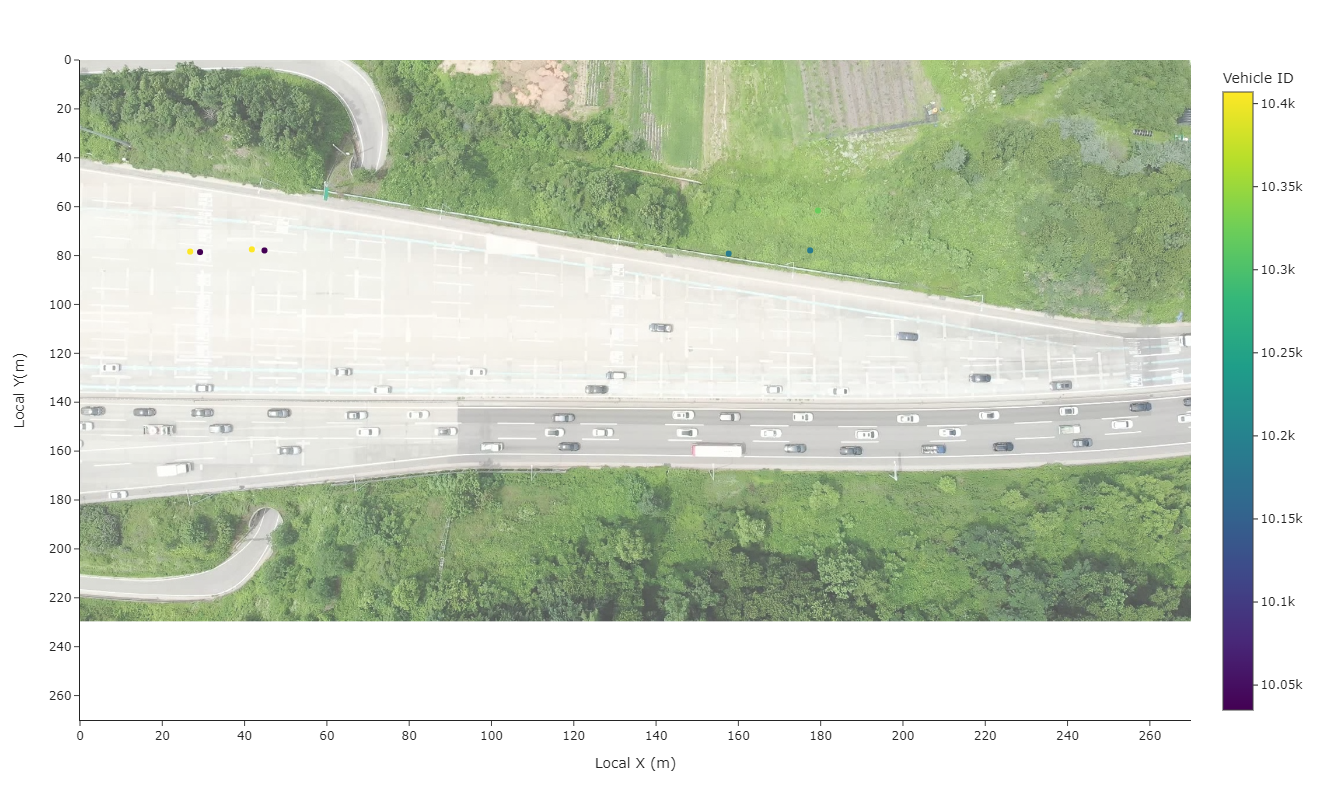

In [38]:
fig = px.scatter(cumsum_df_list[2][cumsum_df_list[2]['decision_3'] == '1초간 6도 이상 변화'], x = 'Local X (m)', y = 'Local Y(m)',
                 color = 'Vehicle ID',
                 template = 'simple_white',
                width = 850, height = 800
                )

fig.update_xaxes(range = [0, 270], dtick = 20)
fig.update_yaxes(range = [270, 0], dtick = 20)

fig.add_layout_image(
    dict(#row = 1,
        #col = 1,
        source = 'https://i.imgur.com/tEA0U25.jpg',
        xref = 'x domain',
        yref = 'y domain',
        x = 1,
        y = 1,
        xanchor = 'right',
        yanchor = 'top',
        sizex = 1,
        sizey = 1,
        #sizing = "stretch",
        opacity = 0.7,
        layer = "below"))
    
fig.show()

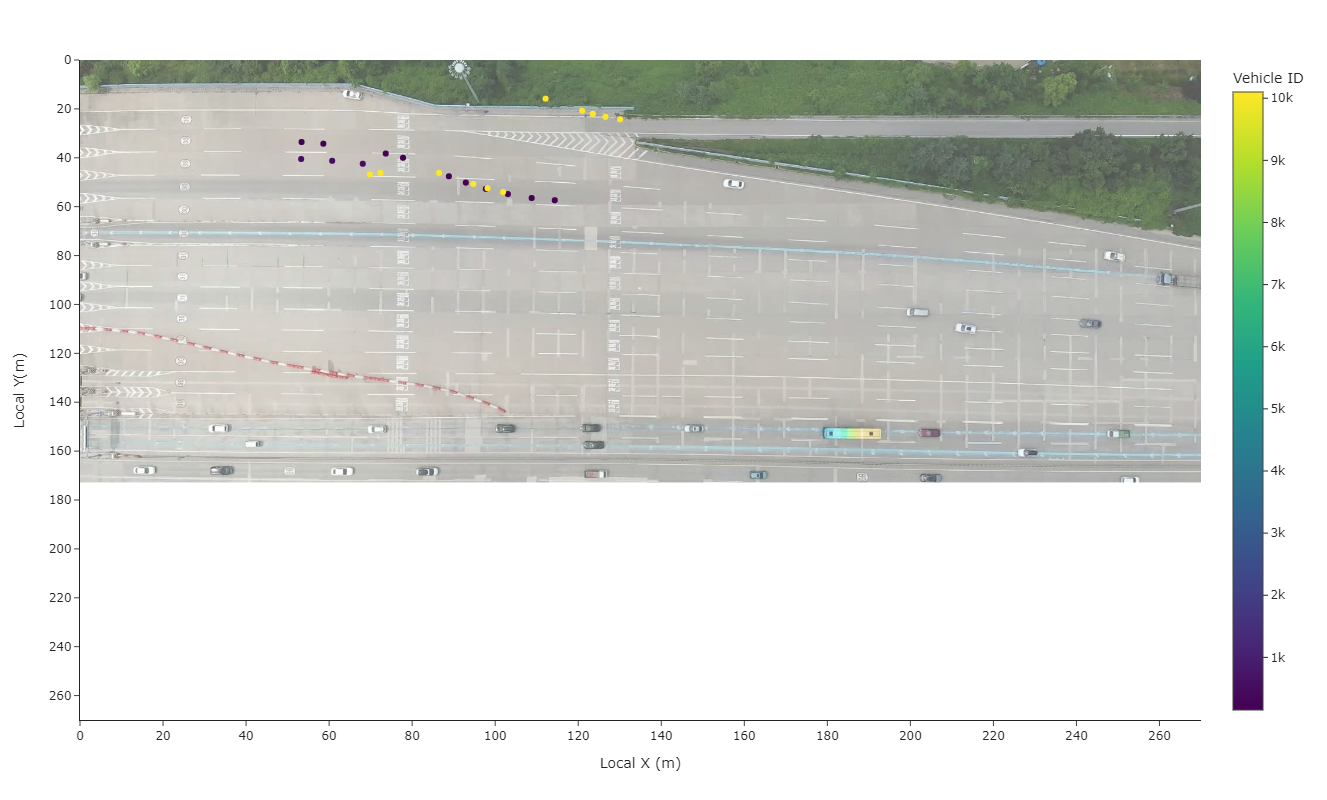

In [35]:
fig = px.scatter(cumsum_df_list[-2][cumsum_df_list[-2]['decision_3'] == '1초간 6도 이상 변화'], x = 'Local X (m)', y = 'Local Y(m)',
                 color = 'Vehicle ID',
                 template = 'simple_white',
                width = 850, height = 800
                )

fig.update_xaxes(range = [0, 270], dtick = 20)
fig.update_yaxes(range = [270, 0], dtick = 20)

fig.add_layout_image(
    dict(#row = 1,
        #col = 1,
        source = 'https://i.imgur.com/WOhlomC.jpg',
        xref = 'x domain',
        yref = 'y domain',
        x = 1,
        y = 1,
        xanchor = 'right',
        yanchor = 'top',
        sizex = 1,
        sizey = 1,
        #sizing = "stretch",
        opacity = 0.7,
        layer = "below"))
    
fig.show()

In [ ]:
fig = px.scatter(sam, x = 'Local X (m)', y = 'Local Y(m)',
                 color = 'Vehicle ID',
                 template = 'simple_white',
                width = 850, height = 800
                )

fig.update_xaxes(range = [0, 270], dtick = 20)
fig.update_yaxes(range = [270, 0], dtick = 20)

fig.add_layout_image(
    dict(#row = 1,
        #col = 1,
        source = 'https://i.imgur.com/FTEMGIw.jpg',
        xref = 'x domain',
        yref = 'y domain',
        x = 1,
        y = 1,
        xanchor = 'right',
        yanchor = 'top',
        sizex = 1,
        sizey = 1,
        #sizing = "stretch",
        opacity = 0.7,
        layer = "below"))
    
fig.show()

In [ ]:
folder_name = '03-5_decision'

save_pv_dir = os.path.join(folder_dir, folder_name)

os.makedirs(save_pv_dir, exist_ok = True) # 해당 경로가 없을 시 폴더 생성, 존재할 경우 건너뛰기

In [ ]:
harmonic = lambda x: statistics.harmonic_mean(list(x))
harmonic .__name__ = 'harmonic'

unq = lambda x: len(x.unique())
unq .__name__ = 'unq'

In [ ]:
for cumsum_df, num_LOS in tqdm(zip(cumsum_df_list, num_LOS_list)):
    
    pvdf = pd.pivot_table(cumsum_df,
                          index = ['Lane_record', 'decision_or', 'decision_5s'],
                          values = ['Vehicle ID', 'Vehicle Velocity(km/h)', 'Vehicle Acceleration'],
                          aggfunc = {'Vehicle ID': unq,
                                     'Vehicle Velocity(km/h)': harmonic,
                                     'Vehicle Acceleration': 'mean'})
    
    if len(pvdf) > 0:
        save_pv_name = f'{num_LOS}.csv'
        save_pv_path = os.path.join(save_pv_dir, save_pv_name)
        
        pvdf.to_csv(save_pv_path, encoding = 'cp949')
    
    else:
        pass